## Assignment2: Building a Small-Scale Foundation Model_7374_Yuqi Lai


In [84]:
from google.colab import drive
from datasets import load_from_disk
from transformers import AutoTokenizer
import os

In [2]:
drive.mount('/content/drive')

load_path = "/content/drive/MyDrive/CSYE7374_Assignment2_Data"

print(f"Loading data from: {load_path} ...")

tokenizer = AutoTokenizer.from_pretrained(f"{load_path}/tokenizer_save")
dataset = load_from_disk(f"{load_path}/dataset_128")

print(dataset)
print("Data loaded successfully!")

print(f"Sample Length: {len(dataset[0]['input_ids'])}")

Mounted at /content/drive
Loading data from: /content/drive/MyDrive/CSYE7374_Assignment2_Data ...
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1934216
})
Data loaded successfully!
Sample Length: 128


## 1. Configuration

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split

In [4]:
BLOCK_SIZE = 128
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SAVE_DIR = "/content/drive/MyDrive/CSYE7374_Assignment2_Data"

DEFAULT_CONFIG = {
    'batch_size': 128,
    'epochs': 2,
    'lr': 5e-4,
    'embed_dim': 256,
    'num_heads': 4,
    'num_layers': 2
}

print(f"Using device: {DEVICE}")

Using device: cuda


## 2. Data Preparation

In [5]:
full_dataset_original = dataset

# 10%
subset_ratio = 0.1
subset_size = int(len(full_dataset_original) * subset_ratio)

full_dataset = full_dataset_original.select(range(subset_size))

print(f"   Original dataset: {len(full_dataset_original)}")
print(f"   Current dataset size: {len(full_dataset)}")

train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

print(f"   - Training Samples:   {len(train_ds)}")
print(f"   - Validation Samples: {len(val_ds)}")

   Original dataset: 1934216
   Current dataset size: 193421
   - Training Samples:   174078
   - Validation Samples: 19343


## 3. Model Implementation

In [53]:
class MiniGPT(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, block_size):
        super(MiniGPT, self).__init__()

        # token and positional embeddings
        self.token_emb = nn.Embedding(vocab_size, embed_dim)
        self.pos_emb = nn.Embedding(block_size, embed_dim)

        # transformer encoder
        layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(layer, num_layers=num_layers)

        # final normalization and output head
        self.ln = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, vocab_size)
        self.block_size = block_size

    def forward(self, idx, targets=None):
        B, T = idx.shape
        pos = torch.arange(0, T, device=idx.device)

        x = self.token_emb(idx) + self.pos_emb(pos)

        # causal mask: block attention to future tokens
        mask = torch.triu(torch.full((T, T), float('-inf'), device=idx.device), diagonal=1)

        x = self.transformer(x, mask=mask)
        x = self.ln(x)
        logits = self.head(x)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                targets.reshape(-1)
            )
        return logits, loss


In [54]:
model_test = MiniGPT(
    vocab_size=tokenizer.vocab_size,
    embed_dim=256,
    num_heads=4,
    num_layers=2,
    block_size=BLOCK_SIZE
).to(DEVICE)

batch = next(iter(temp_loader))
inputs = batch['input_ids'].to(DEVICE)
targets = batch['labels'].to(DEVICE)
logits, loss = model_test(inputs, targets)

print(f"Logits shape: {logits.shape}")
print(f"Loss: {loss.item()}")

Logits shape: torch.Size([4, 128, 32000])
Loss: 10.494041442871094


## 4. Training

In [65]:
from tqdm import tqdm

In [79]:
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0

    progress_bar = tqdm(dataloader, desc="Training", leave=False)

    for batch in progress_bar:
        batch = batch.to(device)

        X = batch[:, :-1] # X: all tokens except the last
        Y = batch[:, 1:] # Y: all tokens except the first

        optimizer.zero_grad()

        logits, loss = model(X, Y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / len(dataloader)

In [80]:
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0.0

    progress_bar = tqdm(dataloader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for batch in progress_bar:
            batch = batch.to(device)

            X = batch[:, :-1]
            Y = batch[:, 1:]


            logits, loss = model(X, Y)

            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)

    try: # catch overflow
        ppl = math.exp(avg_loss)
    except OverflowError:
        ppl = float('inf')

    return avg_loss, ppl

In [81]:
def collate_fn(batch):
    batch_input_ids = [item['input_ids'] for item in batch]
    # ->PyTorch Tensor
    return torch.tensor(batch_input_ids, dtype=torch.long)

In [82]:
def run_experiment(exp_name, config):
    print(f"\nRunning experiment: {exp_name}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    # Build DataLoaders
    train_loader = DataLoader(
        train_ds,
        batch_size=config["batch_size"],
        shuffle=True,
        collate_fn=collate_fn
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=config["batch_size"],
        shuffle=False,
        collate_fn=collate_fn
    )

    model = MiniGPT(
        vocab_size=tokenizer.vocab_size,
        embed_dim=config["embed_dim"],
        num_heads=config["num_heads"],
        num_layers=config["num_layers"],
        block_size=BLOCK_SIZE
    ).to(device)

     # AdamW optimizer and history tracker
    optimizer = optim.AdamW(model.parameters(), lr=config["lr"])
    history = {"train_loss": [], "val_loss": [], "val_perp": []}
    # Training loop
    for epoch in range(config["epochs"]):
        train_loss = train_one_epoch(model, train_loader, optimizer, device)
        val_loss, val_ppl = evaluate(model, val_loader, device)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_perp"].append(val_ppl)

        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val PPL: {val_ppl:.2f}")

    os.makedirs("checkpoints", exist_ok=True)
    save_path = f"checkpoints/{exp_name}_ckpt.pt"
    torch.save(model.state_dict(), save_path)
    print(f"Saved model to {save_path}")

    return history

## 5. Visualization

In [85]:
# Experiment A: baseline learning rate (5e-4)
stats_a = run_experiment("Exp_Baseline", config_a)


Running experiment: Exp_Baseline
Using device: cuda


Epoch 1 | Train Loss: 6.5410 | Val PPL: 418.52


Epoch 2 | Train Loss: 5.8926 | Val PPL: 303.34
Saved model to checkpoints/Exp_Baseline_ckpt.pt


In [86]:
# Experiment B: higher learning rate (1e-3)
config_b = DEFAULT_CONFIG.copy()
config_b["lr"] = 1e-3
stats_b = run_experiment("Exp_HighLR", config_b)


Running experiment: Exp_HighLR
Using device: cuda


Epoch 1 | Train Loss: 6.3310 | Val PPL: 325.85


Epoch 2 | Train Loss: 5.6593 | Val PPL: 244.37
Saved model to checkpoints/Exp_HighLR_ckpt.pt


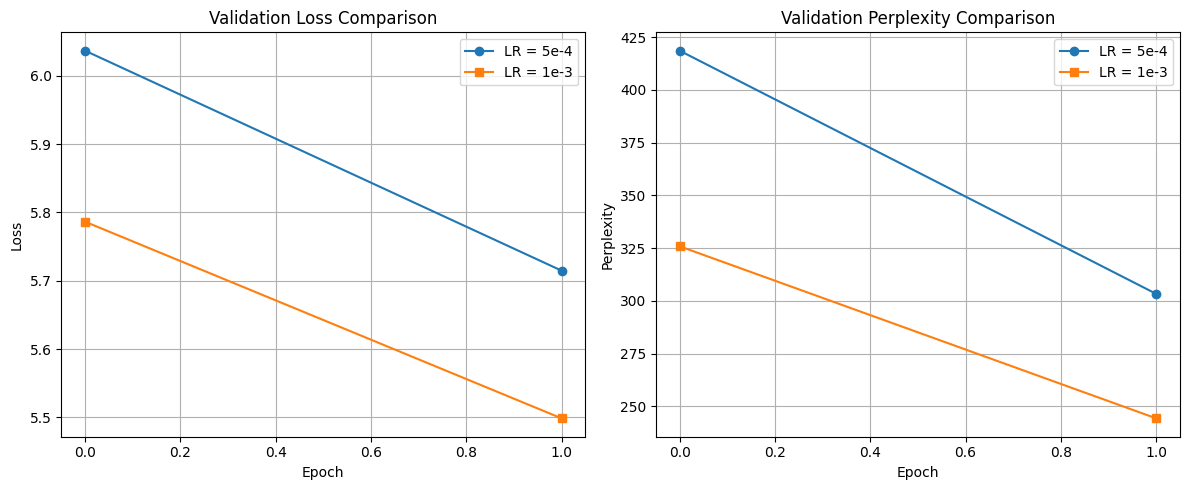

In [87]:
plt.figure(figsize=(12, 5))

# loss
plt.subplot(1, 2, 1)
plt.plot(stats_a["val_loss"], label="LR = 5e-4", marker="o")
plt.plot(stats_b["val_loss"], label="LR = 1e-3", marker="s")
plt.title("Validation Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Perplexity
plt.subplot(1, 2, 2)
plt.plot(stats_a["val_perp"], label="LR = 5e-4", marker="o")
plt.plot(stats_b["val_perp"], label="LR = 1e-3", marker="s")
plt.title("Validation Perplexity Comparison")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 6. Checkpoint Loading

In [96]:
import torch

# 1. Recreate the same model architecture
loaded_model = MiniGPT(
    vocab_size=tokenizer.vocab_size,
    embed_dim=DEFAULT_CONFIG['embed_dim'],
    num_heads=DEFAULT_CONFIG['num_heads'],
    num_layers=DEFAULT_CONFIG['num_layers'],
    block_size=BLOCK_SIZE
).to(DEVICE)

# 2. Load checkpoint
ckpt_path = "checkpoints/Exp_Baseline_ckpt.pt"
if os.path.exists(ckpt_path):
    state_dict = torch.load(ckpt_path, map_location=DEVICE)
    loaded_model.load_state_dict(state_dict)
    loaded_model.eval()
    print(f"Checkpoint loaded successfully from: {ckpt_path}")
else:
    print(f"Checkpoint not found: {ckpt_path}")

# 3. Simple inference function
def generate_text(model, start_str, max_len=50):
    model.eval()
    if not start_str: start_str = "The"

    with torch.no_grad():
        context = tokenizer(start_str, return_tensors='pt')['input_ids'].to(DEVICE)

        for _ in range(max_len):
            x = context[:, -BLOCK_SIZE:]

            logits, _ = model(x)
            logits = logits[:, -1, :]
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            context = torch.cat([context, next_token], dim=1)

    return tokenizer.decode(context[0], skip_special_tokens=True)

# Test generation
print("=== Test Generation ===")
print(generate_text(loaded_model, "Last year"))

Checkpoint loaded successfully from: checkpoints/Exp_Baseline_ckpt.pt
=== Test Generation ===
Last year. already you like a scorp-long doctor about not about allowed girls in the national.hello on saturday, marcel is leaving their own social home newsden, it is an assignment 500 million that carry signs and more of them. cracy should be
